# Multi-Modal RAG
with LlamaIndex and Gemini  
Code accompanies Medium [article](https://medium.com/@gmarchetti/unlock-sharepoint-with-google-gemini-and-llamaindex-bab54f77ab90).  

In this example, we:
- Download some documents containing text and pictures or diagrams
- Create a multimodal data store
- Embed the documents, create a vector index and a retriever
- Given a user's query, retrieve the most relevant paragraphs (pictures and text therein) from the vector store
- And finally generate the answer to the query.

## The problem
* Documents are in Sharepoint
* They are long, complex and multimodal, i.e. they contain pictures and tables.
* Vertex AI Search does not index Sharepoint (yet), nor multimodal documents (yet).
* Access control is required (work in progress - not implemented yet)

## Installations

In [ ]:
#this only works on classic Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade 'llama-index>=0.9.32' 'google-generativeai>=0.3' 'google-ai-generativelanguage>=0.4' matplotlib qdrant_client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.7/598.7 kB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.9/205.9 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.4/223.4 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 66.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ly6hq_8n
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ly6hq_8n
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 963.5 kB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=697cc4698c42eda0c0ef92adafc4107f1583cb1486010fe20771bc0c2a708a99
  Stored in directory: /tmp/pip-ephem-wheel-cache-20owc1xg/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
!pip install pypdf pymupdf frontend tools llama-hub
!pip install sentence-transformers
!pip install pydantic==1.10.11
!pip install open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.9/283.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tools: filename=tools-0.1.9-py3-none-any.whl size=46731 sha256=17817f24cf7f9eb7ac0ca4515af10e29401c3df68a5ebba17727a470fd600670
  Stored in directory: /root/.cache/pip/wheels/c0/d0/70/a33bd4bed2af4f7038b038c16faab552cd0e9d9f4125223a71
  Cre

In [ ]:
!pip install msal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 1.1 MB/s eta 0:00:00


In [ ]:
# Make sure nest_asyncio is installed
!pip install nest_asyncio

**Remember to restart the kernel after the installations**.  
Click Runtime->Restart Session



## Imports

In [ ]:
# import
from llama_index import VectorStoreIndex, SimpleDirectoryReader, Document
from llama_index.vector_stores import QdrantVectorStore
from llama_index.storage.storage_context import StorageContext
from llama_index.service_context import ServiceContext
#from llama_index.embeddings import HuggingFaceEmbedding
from IPython.display import Markdown, display
import qdrant_client

In [ ]:
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
import pypdf
import fitz
import io
import os
from pathlib import Path

In [ ]:
# Allow nested asyncio loops
import asyncio, nest_asyncio
nest_asyncio.apply()

## Set up Gemini
Get your key from [Google AI Studio](https://makersuite.google.com/app/prompts/new_freeform).

In [ ]:
# set up Gemini
GOOGLE_API_KEY = "INSERT_GOOGLE_API_KEY_HERE" # @param {type:"string"}
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [ ]:
# Relax safety settings if documents contain text that may trigger the safety response
safety_settings = [
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_ONLY_HIGH"
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_ONLY_HIGH"
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_ONLY_HIGH"
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_ONLY_HIGH"
  },
]

In [ ]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal
gemini_pro = GeminiMultiModal(model_name="models/gemini-pro-vision", safety_settings=safety_settings)
from llama_index.llms import Gemini
# For RAG applications, keep temperature low 0.0-0.2
gemini = Gemini(model_name="models/gemini-pro", temperature=0.0, max_tokens=2048, safety_settings=safety_settings)
from llama_index.embeddings import GeminiEmbedding
gemini_embedding = GeminiEmbedding(model_name="models/embedding-001")

## Part 1: Multimodal Documents
No Sharepoint required. Just upload at least one PDF in a source directory on your Google Drive.


In [ ]:
SOURCE = "./pdfs/" # @param {type:"string"}

Specify where to store the documents database (local instance only)

In [ ]:
DOCDB = "./QDrant.db" # @param {type:"string"}

Specify where to store the pre-processed documents.

In [ ]:
TARGET = "./mixed_docs/" # @param {type:"string"}

In [ ]:
# Helper function to plot images
def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 10))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


In [ ]:
data_path = Path(TARGET)
if not data_path.exists():
    Path.mkdir(data_path)

### Split PDFs
Extract text and images in a PDF file. It is also possible to extract tables.

In [ ]:
def split_pdf(input_file, output_path):
    file_name=input_file.split('/')[-1].split('.')[0]
    pdf_file = open(input_file, "rb")
    pdf_reader = pypdf.PdfReader(pdf_file)
    text = ""
    for page_num in range(len(pdf_reader.pages)):
        page = pdf_reader.pages[page_num]
        text += page.extract_text()

    with open(output_path+file_name+"_text.txt", "w") as f:
        f.write(text)
    f.close()
    pdf_file.close()

    pdf_file = fitz.open(input_file)
    # iterate over pdf pages
    for page_index in range(len(pdf_file)):
        # get the page itself
        page = pdf_file[page_index]
        image_list = page.get_images()
        # printing number of images found in this page
        if image_list:
            print(f"[+] Found a total of {len(image_list)} images in page {page_index}")
        else:
            print("[!] No images found on page", page_index)
        for image_index, img in enumerate(page.get_images(), start=1):
            # get the XREF of the image
            xref = img[0]
            # extract the image bytes
            base_image = pdf_file.extract_image(xref)
            image_bytes = base_image["image"]
            # get the image extension
            image_ext = base_image["ext"]
            # load it to PIL
            image = Image.open(io.BytesIO(image_bytes))
            # save it to local disk
            image.save(open(output_path+f"{file_name}_image{page_index+1}_{image_index}.{image_ext}", "wb"))

In [ ]:
# prompt: using split_pdf function, write code to run it on all pdf files in source directory and save results in target directory

for pdf_file in os.listdir(SOURCE):
    if pdf_file.endswith(".pdf"):
        split_pdf(SOURCE+pdf_file, TARGET)


[+] Found a total of 2 images in page 0
[!] No images found on page 1
[!] No images found on page 2
[!] No images found on page 3
[!] No images found on page 4
[!] No images found on page 5
[!] No images found on page 6
[!] No images found on page 7
[!] No images found on page 8
[+] Found a total of 1 images in page 9
[+] Found a total of 2 images in page 10
[+] Found a total of 1 images in page 11
[+] Found a total of 1 images in page 12
[!] No images found on page 13
[!] No images found on page 14
[!] No images found on page 15
[!] No images found on page 16
[!] No images found on page 17
[!] No images found on page 18
[!] No images found on page 19
[!] No images found on page 20
[+] Found a total of 5 images in page 21
[!] No images found on page 22
[!] No images found on page 23
[!] No images found on page 24
[!] No images found on page 25
[!] No images found on page 26
[+] Found a total of 1 images in page 27
[!] No images found on page 28
[!] No images found on page 29
[!] No ima

## Create a vector store

In [ ]:
# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path=DOCDB)

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store,
)

## Create a multimodal index
By default images are encoded using the OpenClip model. As of writing, vertex ai multimodal embeddings are not supported by llamaindex yet.

In [ ]:
from llama_index.node_parser import SentenceSplitter, TokenTextSplitter
from llama_index.extractors import (
    SummaryExtractor,
    QuestionsAnsweredExtractor,
    TitleExtractor,
    KeywordExtractor,
    EntityExtractor,
)

transformations=[TokenTextSplitter(chunk_size=512, chunk_overlap=20),
                 #KeywordExtractor(llm=gemini) # metadata extractors tend to time out because they run out of quota
                ]

from llama_index.service_context import ServiceContext
service_context=ServiceContext.from_defaults(
    llm=gemini,
    embed_model=gemini_embedding,
    transformations=transformations
)

In [ ]:
loop = asyncio.get_event_loop()

async def create_mm_index():
    return MultiModalVectorStoreIndex.from_documents(
        documents,
        storage_context=storage_context,
        service_context=service_context,
    )

In [ ]:
# Create the MultiModal index
documents = SimpleDirectoryReader(TARGET).load_data()
index = loop.run_until_complete(create_mm_index())

## Query

In [ ]:
from llama_index.prompts import PromptTemplate
from llama_index.query_engine import SimpleMultiModalQueryEngine

qa_template = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "If the context contains no information to answer the query,"
    "state that the context provided does not contain relevant information.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_template)

query_engine = index.as_query_engine(
    multi_modal_llm=gemini_pro, text_qa_template=qa_tmpl
)


In [ ]:
query_engine.retriever.image_similarity_top_k=2
query_engine.retriever.text_similarity_top_k=2

In [ ]:
query="What is a control moment gyroscope? Explain reasons of its failure." #@param {type:"string"}

In [ ]:
response = query_engine.query(query)

Query: What is a control moment gyroscope? Explain reasons of its failure.
Retrieved Images:



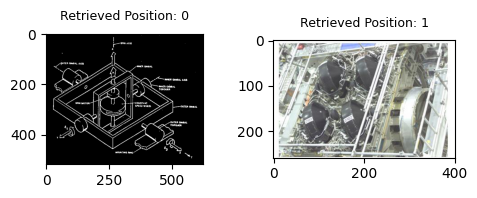

Response:  A control moment gyroscope (CMG) is a type of actuator used to control the attitude of a spacecraft. It consists of a spinning wheel mounted on a gimbal, which allows it to be pointed in any direction. By changing the speed of the wheel and the angle of the gimbal, the CMG can create a torque that will cause the spacecraft to rotate.

CMGs are used on a variety of spacecraft, including the International Space Station (ISS). The ISS has four CMGs, which are used to control the attitude of the station as it orbits the Earth.

CMGs can fail for a variety of reasons, including mechanical failures, electrical failures, and software errors. In the case of the ISS, one of the CMGs failed in 2007 due to a mechanical failure. The CMG was replaced, and the ISS continued to operate normally.

The context provided does not contain any information about the reasons for the failure of the CMGs on the ISS.



In [ ]:
from llama_index.response.notebook_utils import (
    display_query_and_multimodal_response,
)

display_query_and_multimodal_response(query, response)

In [ ]:
print(str(response))

 A control moment gyroscope (CMG) is a type of actuator used to control the attitude of a spacecraft. It consists of a spinning wheel mounted on a gimbal, which allows it to be pointed in any direction. By changing the speed of the wheel and the angle of the gimbal, the CMG can create a torque that will cause the spacecraft to rotate.

CMGs are used on a variety of spacecraft, including the International Space Station (ISS). The ISS has four CMGs, which are used to control the attitude of the station as it orbits the Earth.

CMGs can fail for a variety of reasons, including mechanical failures, electrical failures, and software errors. In the case of the ISS, one of the CMGs failed in 2007 due to a mechanical failure. The CMG was replaced, and the ISS continued to operate normally.

The context provided does not contain any information about the reasons for the failure of the CMGs on the ISS.


**Node ID:** 4d183ff2-0625-4b33-b52c-cf911775a0d7<br>**Similarity:** 0.7319974270142829<br>**Text:** The Aerospace Corporation, L-3 S&N, and independent consultants resulted in comprehensive inve stigations that resulted in identifying the most 
probable cause for both anomalie s. Accolades we re ...<br>

**Node ID:** f2555cc7-88b1-4b9a-b20a-d9189a2007d3<br>**Similarity:** 0.7118768183827231<br>**Text:** NASA/CP-2010-216272<br>

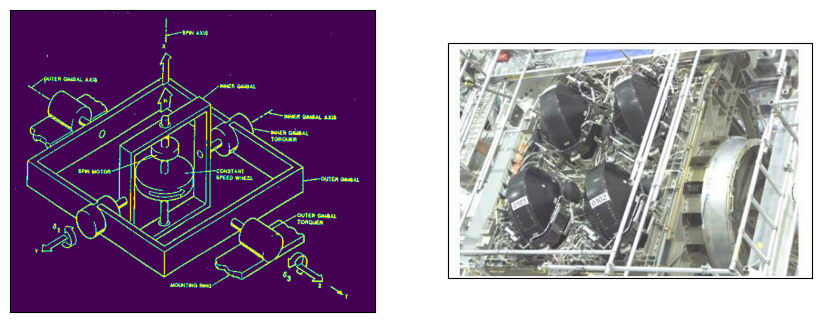

In [ ]:
# show sources
from llama_index.response.notebook_utils import display_source_node

for text_node in response.metadata["text_nodes"]:
    display_source_node(text_node, source_length=200)
plot_images(
    [n.metadata["file_path"] for n in response.metadata["image_nodes"]]
)

## A Simple chatbot

In [ ]:
from llama_index.memory import ChatMemoryBuffer

memory = ChatMemoryBuffer.from_defaults(token_limit=4096)

chat_engine = index.as_chat_engine(
    chat_mode="condense_plus_context",
    memory=memory,
    context_prompt=(
        "You are a chatbot."
        "Here are the relevant documents for the context:\n"
        "{context_str}"
        "\nInstruction: Use the previous chat history, or the context above, to interact and help the user."
    ),
    llm=gemini,
    verbose=False,
)

In [ ]:
def chatbot():
    quit=False
    while quit == False:
        question = str(input('\n\nQuestion: '))
        ## quit command
        if question == 'quit()':
            chat_engine.reset()
            quit=True
        ## clear context command
        elif question=="clear()":
            chat_engine.reset()
            print("Context cleared.\n")
        else:
            response = chat_engine.chat(question) #context+"\n" context becomes too long for Clip
            print(str(response.response))
            #display_query_and_multimodal_response(question, response)


In [ ]:
chatbot()



Question:  why did cmg1 fail on the space station?


The exact cause of CMG1's failure on the space station is not specified in the context. However, it is mentioned that the failure was preceded by an increase in the Spin Motor Command Current (SMCC), which is an indicator of the combined bearing torques. This increase in SMCC was later concluded to be the start of the failure and was caused by an increase in the Hall Resolver side bearing torque. The increase in bearing temperature also indicated that the Hall Resolver side bearing may be in distress.

Additionally, the context mentions that high gimbal rates were identified as a contributor to the failure. As a result, GN&C engineers limited all CMG gimbal rates to 0.014 rad/s (0.8 deg/s) within the GN&C software.

Therefore, it is possible that the combination of high gimbal rates and the bearing issue led to the failure of CMG1 on the space station.
The exact cause of CMG1's failure on the space station is not specified in the context. However, it is mentioned that the failure was p



Question:  quit()


## Part 2: Azure / Sharepoint integration
Let's access Onedrive (personal or business aka Sharepoint library) directly.  
If you want to use Onedrive personal, you will have to run this notebook locally in order to complete the authentication workflow with your local browser.
Register an application in your Azure AD tenant as described in the accompanying [article](https://medium.com/@gmarchetti/unlock-sharepoint-with-google-gemini-and-llamaindex-bab54f77ab90).  
**Note:** This part is NOT multimodal. The loader ingests text only. It is possible to make it multimodal.

Specify sharepoint folder path relative to your library.

In [ ]:
SHAREPOINT_FOLDER = "experiments/multimodal/pdfs" # @param {type:"string"}

Specify where to store the documents database (local instance only)

In [ ]:
DOCDB = "./QDrant-Sharepoint.db" # @param {type:"string"}

Now provide parameters supplied by MS Azure AD.

In [ ]:
# Your Azure AD Client ID
CLIENT_ID = "Azure_AD_client_id_here" # @param {type:"string"}

In [ ]:
# tenant_id is "consumers" for personal onedrive, or provided by Azure AD for Sharepoint
TENANT_ID="consumers" # @param {type:"string"}

In [ ]:
#CLIENT_SECRET="your_secret_for_Sharepoint" # @param {type:"string"}

In [ ]:
#USER_PRINCIPAL_NAME = "your_name@your_org.onmicrosoft.com" # @param {type:"string"}

In [ ]:
from llama_index import download_loader

In [ ]:
OneDriveReader = download_loader("OneDriveReader")

In [ ]:
loader = OneDriveReader(
    client_id = CLIENT_ID,
    tenant_id= TENANT_ID,
    #client_secret=CLIENT_SECRET
)

In [ ]:
documents=loader.load_data(
    folder_path=SHAREPOINT_FOLDER,
    # userprincipalname is required for Sharepoint and provided by Azure AD
    # userprincipalname = USER_PRINCIPAL_NAME
)

In [ ]:
len(documents)

1705

## Create a vector store

In [ ]:
# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path=DOCDB)
# This time it has only 1 collection for text
text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)

storage_context = StorageContext.from_defaults(
    vector_store=text_store,
)

## Create an index


In [ ]:
from llama_index.text_splitter import SentenceSplitter, TokenTextSplitter
from llama_index.extractors import TitleExtractor, SummaryExtractor, KeywordExtractor

transformations=[TokenTextSplitter(chunk_size=1024, chunk_overlap=20),
                 TitleExtractor(llm=gemini, nodes=5), #these do not seem to work with Gemini
                 #SummaryExtractor(llm=gemini, nodes=1),
                 #KeywordExtractor(llm=gemini, keywords=2)
                 ]

service_context=ServiceContext.from_defaults(
    llm=gemini,
    embed_model=gemini_embedding,
    transformations=transformations
)

In [ ]:
async def create_index():
    return VectorStoreIndex.from_documents(
        documents,
        storage_context=storage_context,
        service_context=service_context,
        show_progress=True
    )

In [ ]:
loop = asyncio.get_event_loop()
index=loop.run_until_complete(create_index())

Parsing nodes:   0%|          | 0/1705 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.31s/it]


Generating embeddings:   0%|          | 0/1893 [00:00<?, ?it/s]

## A Simple chatbot

In [ ]:
from llama_index.memory import ChatMemoryBuffer

memory = ChatMemoryBuffer.from_defaults(token_limit=4096)

chat_engine = index.as_chat_engine(
    chat_mode="condense_plus_context",
    memory=memory,
    context_prompt=(
        "You are a chatbot."
        "Here are the relevant documents for the context:\n"
        "{context_str}"
        "\nInstruction: Use the previous chat history, or the context above, to interact and help the user."
    ),
    llm=gemini,
    verbose=False,
)

In [ ]:
def chatbot():
    quit=False
    while quit == False:
        question = str(input('\n\nQuestion: '))
        ## quit command
        if question == 'quit()':
            chat_engine.reset()
            quit=True
        ## clear context command
        elif question=="clear()":
            chat_engine.reset()
            print("Context cleared.\n")
        else:
            response = chat_engine.chat(question)
            print(str(response.response))


In [ ]:
chatbot()



Question:  how did the wfp react to covid-19?


The provided context does not contain information about how the WFP reacted to COVID-19. Therefore, I cannot answer this question.




Question:  how did the wfp react to covid-19 in Kenya?


Unfortunately, I do not have access to real-time information or the ability to browse the internet, including the provided URL. Therefore, I cannot provide information about how the WFP reacted to COVID-19 in Kenya.




Question:  what is a control moment gyroscope?


A control moment gyroscope (CMG) is a type of actuator used for attitude control of spacecraft. It consists of a spinning flywheel mounted on a gimbal system, which allows the flywheel's angular momentum to be directed in different directions. By changing the direction of the flywheel's angular momentum, the CMG can exert a torque on the spacecraft, causing it to rotate.

CMGs have several advantages over traditional reaction wheels, which are another type of actuator used for attitude control. First, CMGs can generate much higher torques than reaction wheels, making them more effective for controlling large spacecraft. Second, CMGs do not require any propellant, which makes them more efficient and reliable than reaction wheels.

CMGs are used on a variety of spacecraft, including satellites, space stations, and spacecraft that are used for planetary exploration. Some notable examples of spacecraft that use CMGs include the International Space Station, the Hubble Space Telescope, and t

## Part 3: Text-Only, Google Semantic Retriever
Semantic retriever is a managed index and vector database. As of writing, it works with text only. It is not available with the "free" version of Gemini, hence you'll have to configure a service account for Vertex AI access.

In [ ]:
!pip install google-auth-oauthlib

In [ ]:
CREDENTIALS_FILE = "./genai-service-account-key3.json" # @param {"type": "string"}

In [ ]:
from google.oauth2 import service_account
from llama_index.indices.managed.google.generativeai import set_google_config

credentials = service_account.Credentials.from_service_account_file(
    CREDENTIALS_FILE,
    scopes=[
      'https://www.googleapis.com/auth/cloud-platform', 'https://www.googleapis.com/auth/generative-language.retriever',
    ],
)
set_google_config(auth_credentials=credentials)

LLM is explicitly disabled. Using MockLLM.
Embeddings have been explicitly disabled. Using MockEmbedding.


### Helper functions

In [ ]:
import llama_index.vector_stores.google.generativeai.genai_extension as genaix
from typing import Iterable
from random import randrange


LLAMA_INDEX_COLAB_CORPUS_ID_PREFIX = f"llama-index-colab-part3"
SESSION_CORPUS_ID_PREFIX = (
    f"{LLAMA_INDEX_COLAB_CORPUS_ID_PREFIX}-{randrange(1000000)}"
)


def corpus_id(num_id: int) -> str:
    return f"{SESSION_CORPUS_ID_PREFIX}-{num_id}"


SESSION_CORPUS_ID = corpus_id(1)


def list_corpora() -> Iterable[genaix.Corpus]:
    client = genaix.build_semantic_retriever()
    yield from genaix.list_corpora(client=client)


def delete_corpus(*, corpus_id: str) -> None:
    client = genaix.build_semantic_retriever()
    genaix.delete_corpus(corpus_id=corpus_id, client=client)


def cleanup_colab_corpora():
    for corpus in list_corpora():
        if corpus.corpus_id.startswith(LLAMA_INDEX_COLAB_CORPUS_ID_PREFIX):
            try:
                delete_corpus(corpus_id=corpus.corpus_id)
                print(f"Deleted corpus {corpus.corpus_id}.")
            except Exception:
                pass



In [ ]:
# Remove any previously leftover corpora from this colab.
cleanup_colab_corpora()

### Create Corpus

In [ ]:
CORPUS_NAME = "3PDFs" #@param {"type": "string"}

In [ ]:
SOURCE = "./pdfs/" # @param {type:"string"}

In [ ]:
from llama_index import SimpleDirectoryReader
from llama_index.indices.managed.google.generativeai import GoogleIndex
from llama_index.response import Response
import time

In [ ]:
# Create a corpus.
index = GoogleIndex.create_corpus(
    corpus_id=SESSION_CORPUS_ID, display_name=CORPUS_NAME
)
print(f"Newly created corpus ID is {index.corpus_id}.")

### Ingest documents


In [ ]:
documents = SimpleDirectoryReader(SOURCE).load_data()

In [ ]:
index.insert_documents(documents) # this runs out of quota with a few documents and is otherwise very slow!

In [ ]:
for corpus in list_corpora():
    print(corpus)

Corpus(name='corpora/llama-index-colab-part3-774432-1', display_name='3PDFs', create_time=DatetimeWithNanoseconds(2024, 1, 18, 1, 59, 17, 444318, tzinfo=datetime.timezone.utc), update_time=DatetimeWithNanoseconds(2024, 1, 18, 1, 59, 17, 444318, tzinfo=datetime.timezone.utc))


### Set up AQA-based query engine

In [ ]:
SESSION_CORPUS_ID='llama-index-colab-part3-774432-1'

In [ ]:
# Relax safety settings if documents contain text that may trigger the safety response
safety_settings = [
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_ONLY_HIGH"
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_ONLY_HIGH"
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_ONLY_HIGH"
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_ONLY_HIGH"
  },
]

In [ ]:
from llama_index.response.schema import Response

from google.ai.generativelanguage import (
    GenerateAnswerRequest,
    HarmCategory,
    SafetySetting,
)

In [ ]:
index = GoogleIndex.from_corpus(corpus_id=SESSION_CORPUS_ID)
query_engine = index.as_query_engine(
    # We recommend temperature between 0 and 0.2.
    temperature=0.2,
    # See package `google-generativeai` for other voice styles.
    answer_style=GenerateAnswerRequest.AnswerStyle.ABSTRACTIVE,
    # See package `google-generativeai` for additional safety settings.
    # SAFETY SETTINGS are buggy for AQA
)

In [ ]:
response = query_engine.query("What is a CMG?")

assert isinstance(response, Response)

# Show response.
print(f"Response is {response.response}")

# Show cited passages that were used to construct the response.
for cited_text in [node.text for node in response.source_nodes]:
    print(f"\n\nCited text: {cited_text}")

# Show answerability. 0 means not answerable from the passages.
# 1 means the model is certain the answer can be provided from the passages.
if response.metadata:
    print(
        f"\n\nAnswerability: {response.metadata.get('answerable_probability', 0)}"
    )

Response is CMGs are momentum storage devices that exchange momentum with the ISS through induced gyroscopic torques.


Cited text: 162  
 
Figure 1. CMGs 1-4 Mounted on Z1 Truss 
 
 
Space Station Z1/CMG Configuration2 
 
The four CMGs operate as momentum storage devices that exchange momentum with the ISS through induced gyroscopic torques. These torques are created by a motor-driven constant-speed momentum 
flywheel mounted inside two orthogonal gimbals. Both gimbals have torquer motors and position resolvers mounted on the rotational axis and move by use of a gear train system. The momentum 
flywheel is mounted inside the inner gimbal and is supported by bearings mounted on each side of the flywheel. This configuration is shown in Figure 2.  Double Gimbal CMGs were selected for the ISS 
because of the spherical momentum envelope. The co ntrol law is heuristic with no singularities and 
should the active number of CMGs change, the entire momentum envelope varies in proportion to the